# Метрика

 В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [100]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных

1) Посмотрим на случайные строчки.

2) Посмотрим, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna()

In [102]:
data = pd.read_csv('./train.csv')

In [103]:
# Списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [104]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
890,16,19.75,294.9,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),0
3163,29,101.45,2948.6,Male,1,No,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),0
665,70,80.60,5460.2,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
606,31,80.55,2471.6,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,No,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
1192,1,45.15,45.15,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,1


In [105]:
data.replace('', np.nan)
data.isna().sum()

,0
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


In [106]:
data['TotalSpent'] = data['TotalSpent'].str.replace(' ', '0').astype(float)

#Анализ данных

Построим графики по признакам и проследим зависимости с целевой ппеременной.

[]

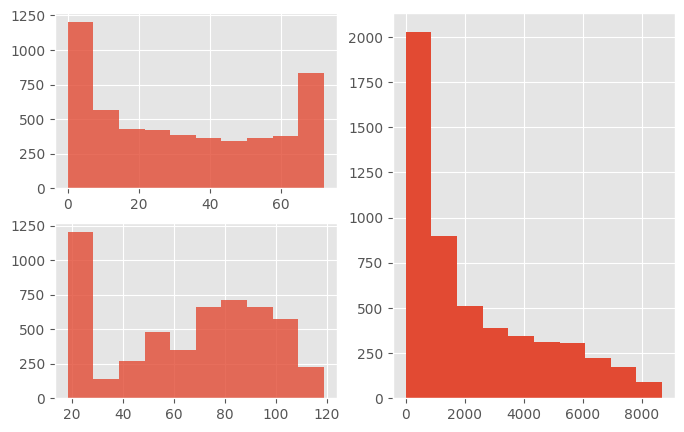

In [107]:
plt.figure(figsize=(8,5))
plt.style.use('ggplot')


plt.subplot(2, 2, 1)
plt.hist(data['ClientPeriod'], alpha=0.8)
plt.subplot(2, 2, 3)
plt.hist(data['MonthlySpending'], alpha=0.8)
plt.subplot(1, 2, 2)
plt.hist(data['TotalSpent'])
plt.plot()

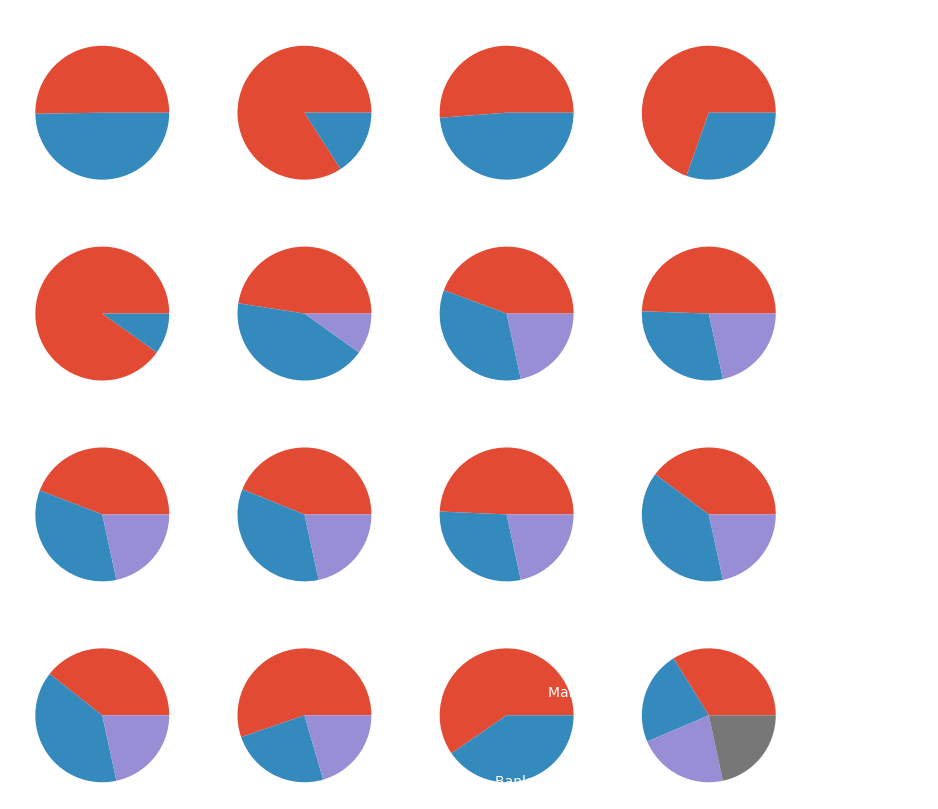

In [108]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')

i=1
for cat in cat_cols:
  plt.subplot(4, 4, i)
  i+=1
  plt.pie(data[cat].astype(str).value_counts(), labels=data[cat].astype(str).value_counts().index)
  plt.title(cat, fontsize='10')

По графикам видно, что выбросов нет.

([<matplotlib.patches.Wedge at 0x7bafb7fd7c70>,
 [Text(-0.7478930722742168, 0.8066324766857789, ''),
  Text(0.7478930722742166, -0.8066324766857789, '')])

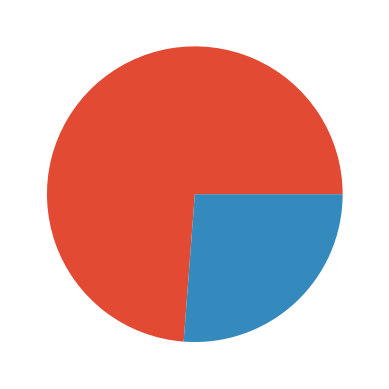

In [109]:
plt.pie(data[target_col].value_counts())

Классы в действительности оказались несбалонсированными

Посмотрим, есть ли корреляция между признаками и целевой переменной:

In [110]:
data[num_cols+[target_col]].corr(numeric_only=True).style.background_gradient(cmap='coolwarm').format(precision=2)

,ClientPeriod,MonthlySpending,TotalSpent,Churn
ClientPeriod,1.00,0.25,0.83,-0.35
MonthlySpending,0.25,1.00,0.65,0.18
TotalSpent,0.83,0.65,1.00,-0.20
Churn,-0.35,0.18,-0.20,1.00


Мы видим большую корреляцию между целевой переменной и суммарными тратами

## Применение линейных моделей

Создадим пайплайн, обрабатывающий отдеально категориальные и численные признаки,и используем LogisticRegression. Подберем значения параметра C по логарифмической шкале с помощью кросс-валидации.

In [111]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [115]:
num_trans = make_pipeline(StandardScaler())
cat_trans = make_pipeline(OneHotEncoder())


preprocessor = ColumnTransformer(
    transformers=[('num', num_trans, num_cols),
                  ('cat', cat_trans, cat_cols)]
    )

pipeline = make_pipeline(preprocessor, LogisticRegression())

params = {
    'logisticregression__C': np.logspace(-3,3,7)
    }

cv = GridSearchCV(pipeline, param_grid=params, scoring='roc_auc', cv=5, verbose = 2)
cv.fit(data[feature_cols], data[target_col])



Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ........................logisticregression__C=0.001; total time=   0.1s
[CV] END ........................logisticregression__C=0.001; total time=   0.1s
[CV] END ........................logisticregression__C=0.001; total time=   0.1s
[CV] END ........................logisticregression__C=0.001; total time=   0.1s
[CV] END ........................logisticregression__C=0.001; total time=   0.1s
[CV] END .........................logisticregression__C=0.01; total time=   0.1s
[CV] END .........................logisticregression__C=0.01; total time=   0.1s
[CV] END .........................logisticregression__C=0.01; total time=   0.1s
[CV] END .........................logisticregression__C=0.01; total time=   0.1s
[CV] END .........................logisticregression__C=0.01; total time=   0.1s
[CV] END ..........................logisticregression__C=0.1; total time=   0.1s
[CV] END ..........................logisticregres

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=10.0; total time=   0.3s
[CV] END .........................logisticregression__C=10.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=10.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=10.0; total time=   0.3s
[CV] END ........................logisticregression__C=100.0; total time=   0.2s
[CV] END ........................logisticregression__C=100.0; total time=   0.2s
[CV] END ........................logisticregression__C=100.0; total time=   0.1s
[CV] END ........................logisticregression__C=100.0; total time=   0.1s
[CV] END ........................logisticregression__C=100.0; total time=   0.1s
[CV] END .......................logisticregression__C=1000.0; total time=   0.1s
[CV] END .......................logisticregression__C=1000.0; total time=   0.2s
[CV] END .......................logisticregression__C=1000.0; total time=   0.1s
[CV] END .......................logisticregression__C=1000.0; total time=   0.1s
[CV] END .......................logisticregression__C=1000.0; total time=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhone...
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod'])])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='roc_auc', verbose=2)

Text(0, 0.5, 'ROC-AUC')

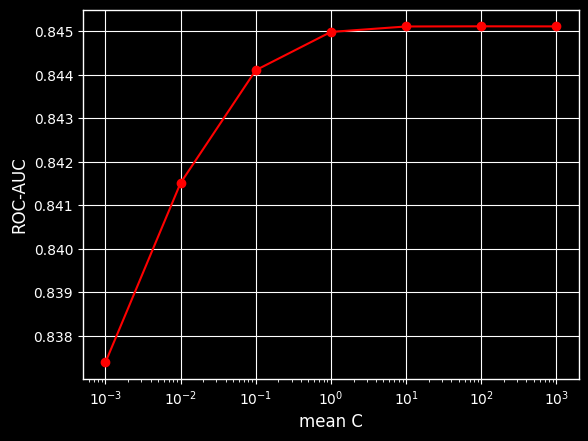

In [117]:
scores = pd.DataFrame(cv.cv_results_)[['param_logisticregression__C','mean_test_score']]

plt.plot(list(cv.cv_results_['param_logisticregression__C']), list(cv.cv_results_['mean_test_score']), 'r-o')
plt.xscale('log')

plt.style.use('dark_background')
plt.xlabel('mean C')
plt.ylabel('ROC-AUC')

Лучшее качество получилось в параметром C=100

In [118]:
cv.best_score_

0.8451139235772726

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию.

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [119]:
!pip install catboost
from catboost import CatBoostClassifier

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data[feature_cols],
    data[target_col],
    test_size=0.2
)
print(X_test.shape, y_test.shape)

(1057, 19) (1057,)


  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'ROC-AUC')

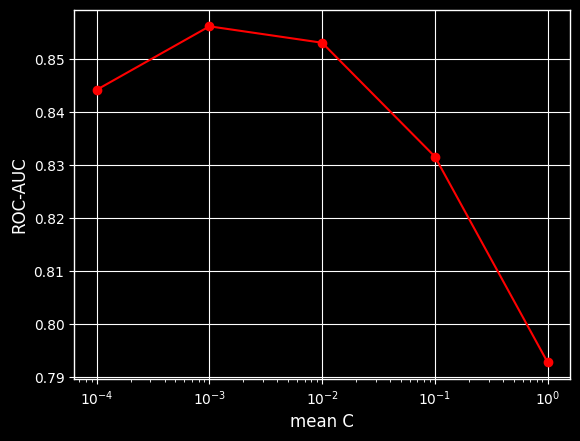

In [153]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

lrs = np.logspace(-4,0,5)
results = []

for lr in tqdm(lrs):
  GradBoost = CatBoostClassifier(
      iterations = 1000,
      learning_rate=lr,
      depth = 6
      )

  GradBoost.fit(
      X_train, y_train,
      cat_features = cat_cols,
      silent=True,
      )
  results.append(roc_auc_score(y_test, GradBoost.predict_proba(X_test).T[1]))

plt.plot(list(lrs), results, 'r-o')
plt.xscale('log')

plt.style.use('dark_background')
plt.xlabel('mean C')
plt.ylabel('ROC-AUC')


Заметим, что показатели достаточно хороши на отрезке [0.0005;0.01], попробуем еще прогнать значения по linspace этого отрезка

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'ROC-AUC')

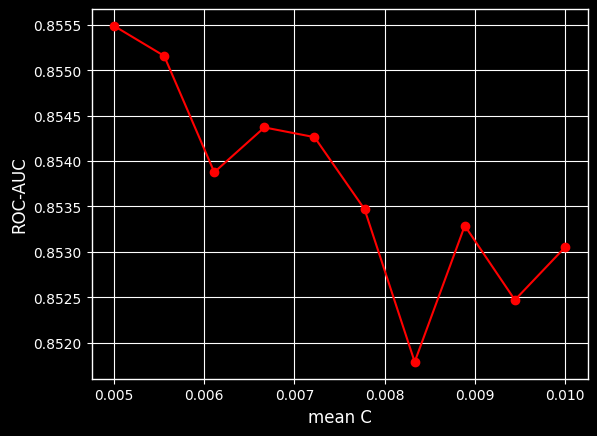

In [154]:
lrs = np.linspace(0.005,0.01,10)
results = []

for lr in tqdm(lrs):
  GradBoost = CatBoostClassifier(
      iterations = 1000,
      learning_rate=lr,
      depth = 6
      )

  GradBoost.fit(
      X_train, y_train,
      cat_features = cat_cols,
      silent=True
      )
  results.append(roc_auc_score(y_test, GradBoost.predict_proba(X_test).T[1]))

plt.plot(list(lrs), results, 'r-o')

plt.style.use('dark_background')
plt.xlabel('mean C')
plt.ylabel('ROC-AUC')


In [155]:
print(max(results), lrs[results.index(max(results))])

0.8554898341583465 0.005


Лучшее качество 0.8555. Получено при значении 0.005

Прогоним тесты для другой глубины дерева и посмотрим на результаты.

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

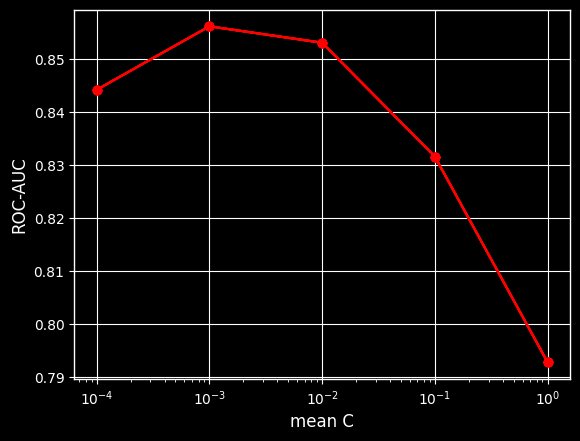

In [156]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

deph = [3,4,5,6,7,8]
lrs = np.logspace(-4,0,5)

mass =[]
for dep in tqdm(deph):
  results = []
  for lr in tqdm(lrs):
    GradBoost = CatBoostClassifier(
        iterations = 1000,
        learning_rate=lr,
        depth = 6
        )

    GradBoost.fit(
        X_train, y_train,
        cat_features = cat_cols,
        silent=True,
        )
    results.append(roc_auc_score(y_test, GradBoost.predict_proba(X_test).T[1]))
  mass.append(results)

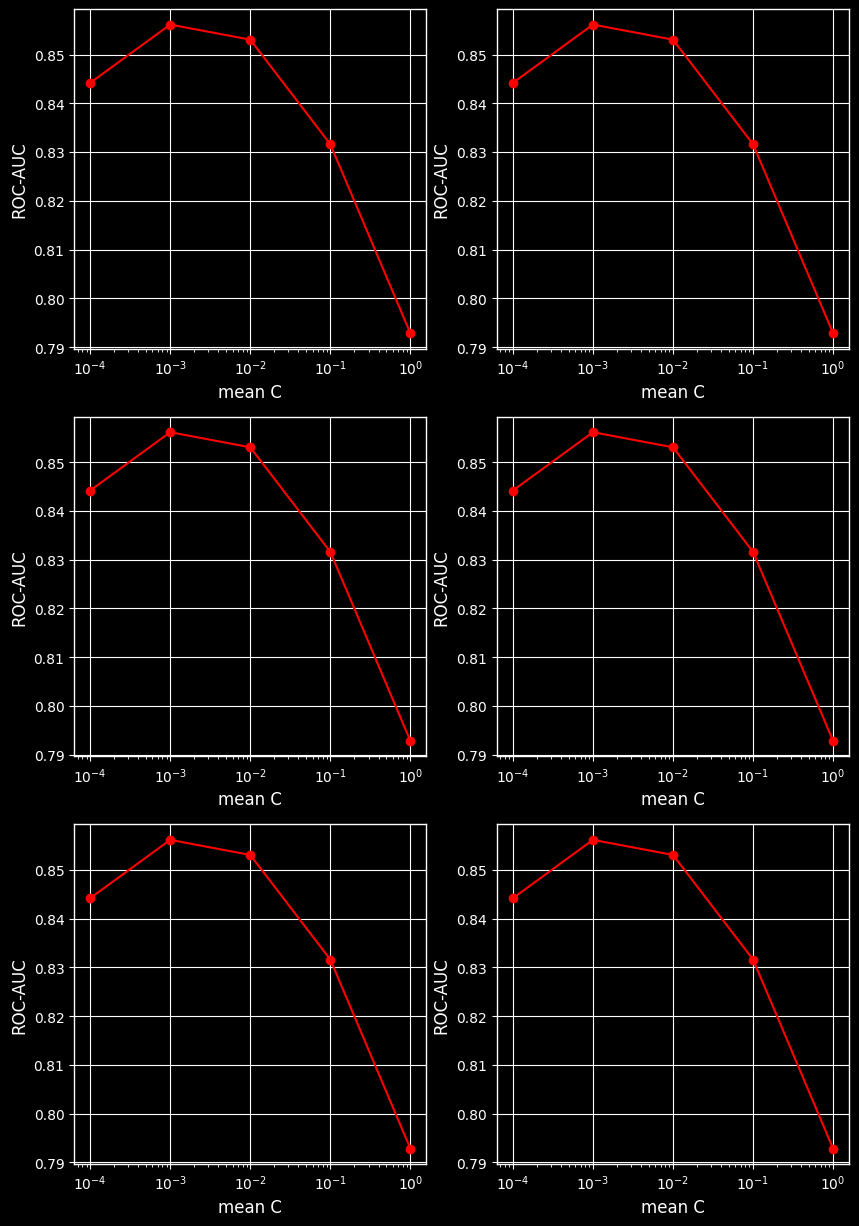

In [162]:
i=1
plt.figure(figsize=(10,15))
for res in mass:
  plt.subplot(3, 2, i)
  i+=1
  plt.plot(list(lrs), res, 'r-o')
  plt.xscale('log')

  plt.style.use('dark_background')
  plt.xlabel('mean C')
  plt.ylabel('ROC-AUC')

In [173]:
arr = np.array(mass)
arr == arr.max()

array([[False,  True, False, False, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False]])

Видно, что от глубины дерева мы не получили значимых изменений. Лучшие результаты все также при lr = 0.001

Оставим прежние параметры и запомним эту модель

In [174]:
model = CatBoostClassifier(
      iterations = 1000,
      learning_rate=0.775,
      depth = 6
      )

model.fit(
      data[feature_cols], data[target_col],
      cat_features = cat_cols,
      silent=True
      )

# Предсказания

In [175]:
best_model = model

In [182]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict(X_test)
submission.to_csv('./my_submission.csv')